In [ ]:
# Invoice Risk & Vendor Exposure Analysis

# This project analyzes invoice payment data to identify unpaid balances,
# vendor risk exposure, and escalation priorities using Python and Pandas.
# Synthetic invoice dates were derived from days overdue to enable
# time-based analysis.

# Data Assumptions:
# Invoice dates were derived using days overdue
# Unpaid invoices represent active financial exposure
# Priority levels reflect escalation urgency

In [1]:
# Generate invoices for the project.

import random

invoices = [
    {"id": "INV001", "vendor": "Amazon", "amount": 450,  "status": "Paid",   "days_overdue": 0},
    {"id": "INV002", "vendor": "Staples","amount": 1200, "status": "Unpaid", "days_overdue": 18},
    {"id": "INV003", "vendor": "FedEx",  "amount": 300,  "status": "Unpaid", "days_overdue": 5},
    {"id": "INV004", "vendor": "UPS",    "amount": 800,  "status": "Paid",   "days_overdue": 0},
    {"id": "INV005", "vendor": "Amazon", "amount": 650,  "status": "Unpaid", "days_overdue": 45},
    {"id": "INV006", "vendor": "Dell",   "amount": 2000, "status": "Unpaid", "days_overdue": 2},
]


random.seed(42)  # ensures reproducibility

vendors = ["Amazon", "Staples", "FedEx", "UPS", "Dell", "Office Depot", "Walmart", "Costco", "Best Buy", "Grainger"]
statuses = ["Paid", "Unpaid"]

starting_id = len(invoices) + 1
target_size = 1000

while len(invoices) < target_size:
    invoice_id = f"INV{starting_id:03d}"
    vendor = random.choice(vendors)

    # realistic amounts
    amount = random.randint(50, 5000)

    # weighted status (more paid than unpaid)
    status = "Unpaid" if random.random() < 0.35 else "Paid"

    # enforce business logic
    if status == "Paid":
        days_overdue = 0
    else:
        days_overdue = random.randint(1, 90)

    invoices.append({
        "id": invoice_id,
        "vendor": vendor,
        "amount": amount,
        "status": status,
        "days_overdue": days_overdue
    })

    starting_id += 1


In [15]:
# Import libraries used for analysis.

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Load the invoices into a dataframe.

df = pd.DataFrame(invoices)

# Generate an invoice date column based on the current date minus the days overdue.

df['invoice_date'] = df['days_overdue'].apply(lambda x: (datetime.now() - timedelta(days=x)).strftime('%Y-%m-%d'))

df = df.sort_values('invoice_date')

df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 903 to 499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1000 non-null   object
 1   vendor        1000 non-null   object
 2   amount        1000 non-null   int64 
 3   status        1000 non-null   object
 4   days_overdue  1000 non-null   int64 
 5   invoice_date  1000 non-null   object
dtypes: int64(2), object(4)
memory usage: 54.7+ KB


,id,vendor,amount,status,days_overdue,invoice_date
903,INV904,Best Buy,3695,Unpaid,90,2025-09-27
395,INV396,Dell,287,Unpaid,90,2025-09-27
751,INV752,Best Buy,2398,Unpaid,90,2025-09-27
148,INV149,Staples,3532,Unpaid,90,2025-09-27
830,INV831,Office Depot,3950,Unpaid,90,2025-09-27


In [3]:
# Priority Mapping

# Creating a priority column to identify high and medium risk invoices based on unpaid status, unpaid amount, and days overdue.

df['priority'] = np.select(
    [
        (df['status'] == 'Unpaid') & ((df['amount'] > 1000) | (df['days_overdue'] > 30)),
        (df['status'] == 'Unpaid')
    ],
    ['HIGH', 'MEDIUM'],
    default='NONE'
)

# Risk Scoring

risk_map = {'HIGH' : 3, 'MEDIUM' : 2, 'NONE' : 1}
df['risk_score'] = df['priority'].map(risk_map)

df

,id,vendor,amount,status,days_overdue,invoice_date,priority,risk_score
903,INV904,Best Buy,3695,Unpaid,90,2025-09-27,HIGH,3
395,INV396,Dell,287,Unpaid,90,2025-09-27,HIGH,3
751,INV752,Best Buy,2398,Unpaid,90,2025-09-27,HIGH,3
148,INV149,Staples,3532,Unpaid,90,2025-09-27,HIGH,3
830,INV831,Office Depot,3950,Unpaid,90,2025-09-27,HIGH,3
...,...,...,...,...,...,...,...,...
415,INV416,Office Depot,640,Paid,0,2025-12-26,NONE,1
417,INV418,Office Depot,4766,Paid,0,2025-12-26,NONE,1
421,INV422,UPS,3619,Paid,0,2025-12-26,NONE,1
424,INV425,Staples,4231,Paid,0,2025-12-26,NONE,1


In [4]:
# Vendor Risk KPI Table

vendor_risk_kpi = (
    df[df['status'] == 'Unpaid']
    .groupby('vendor')
    .agg(
        total_unpaid_amount = ('amount','sum'),
        unpaid_invoice_count = ('id','count'),
        avg_days_overdue = ('days_overdue',lambda x: round(x.mean(),2)),
        high_risk_count = ('priority', lambda x: (x == 'HIGH').sum())

    )
    .sort_values('total_unpaid_amount', ascending=False)
    .reset_index()
)
vendor_risk_kpi

,vendor,total_unpaid_amount,unpaid_invoice_count,avg_days_overdue,high_risk_count
0,Dell,142155,46,39.63,44
1,Walmart,114166,40,45.65,39
2,FedEx,111285,45,40.11,43
3,Staples,109241,41,51.15,40
4,Best Buy,91991,28,53.18,27
5,Grainger,90954,32,46.38,30
6,UPS,78369,29,44.48,28
7,Office Depot,71007,27,42.37,24
8,Costco,69227,27,44.93,22
9,Amazon,64989,34,47.06,30


In [5]:
# Ranking & Exposure Analysis

# Creating a column to rank the risk level of each vendor based on the total unpaid amount.

vendor_risk_kpi['exposure_rank'] = (
    vendor_risk_kpi['total_unpaid_amount']
    .rank(method = 'dense', ascending = False)
    .astype(int)
)

# Set the new exposure rank column as the index column.

vendor_risk_kpi.set_index('exposure_rank', inplace=True)

vendor_risk_kpi

,vendor,total_unpaid_amount,unpaid_invoice_count,avg_days_overdue,high_risk_count
exposure_rank,,,,,
1,Dell,142155,46,39.63,44
2,Walmart,114166,40,45.65,39
3,FedEx,111285,45,40.11,43
4,Staples,109241,41,51.15,40
5,Best Buy,91991,28,53.18,27
6,Grainger,90954,32,46.38,30
7,UPS,78369,29,44.48,28
8,Office Depot,71007,27,42.37,24
9,Costco,69227,27,44.93,22


In [6]:
# Top 5 Vendors by Risk Exposure

top_5_vendors = vendor_risk_kpi.head(5)
top_5_vendors

,vendor,total_unpaid_amount,unpaid_invoice_count,avg_days_overdue,high_risk_count
exposure_rank,,,,,
1,Dell,142155,46,39.63,44
2,Walmart,114166,40,45.65,39
3,FedEx,111285,45,40.11,43
4,Staples,109241,41,51.15,40
5,Best Buy,91991,28,53.18,27


<Axes: xlabel='vendor'>

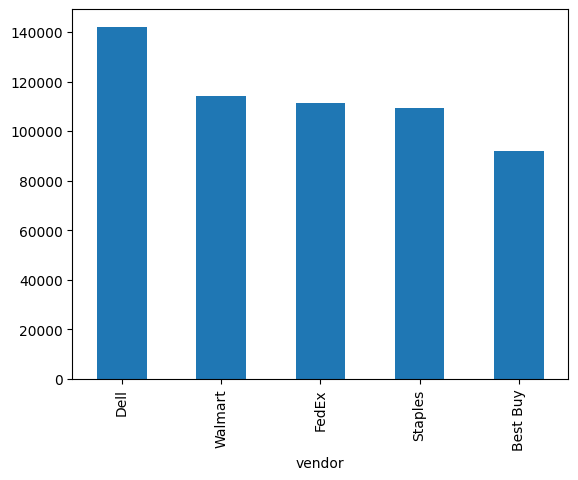

In [7]:
# Visualization of Top 5 Vendors by Risk Exposure.

top_5_vendors.plot(
    x='vendor',
    y='total_unpaid_amount',
    kind='bar',
    legend=False
)


In [8]:
# Aging & Early Warning Indicators

# Created column that separates invoices into bins based on days overdue.

df['aging_bucket'] = pd.cut(
    df['days_overdue'],
    bins=[-1,0,30,60,90,float('inf')],
    labels=['Current','0-30', '31-60', '61-90', '90+']
)

# Summarized the aging buckets into a table showing the total amount and invoice count for each bucket.

aging_bucket_table = (
    df.groupby('aging_bucket')
    .agg(
        total_amount = ('amount','sum'),
        invoice_count = ('id','count')
    )
    .reset_index()
)

aging_bucket_table

/tmp/ipython-input-4035309402.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('aging_bucket')


,aging_bucket,total_amount,invoice_count
0,Current,1669919,651
1,0-30,328984,123
2,31-60,297629,109
3,61-90,316771,117
4,90+,0,0


<Axes: title={'center': 'Total Amount by Aging Bucket'}, xlabel='Aging Bucket', ylabel='Total Amount'>

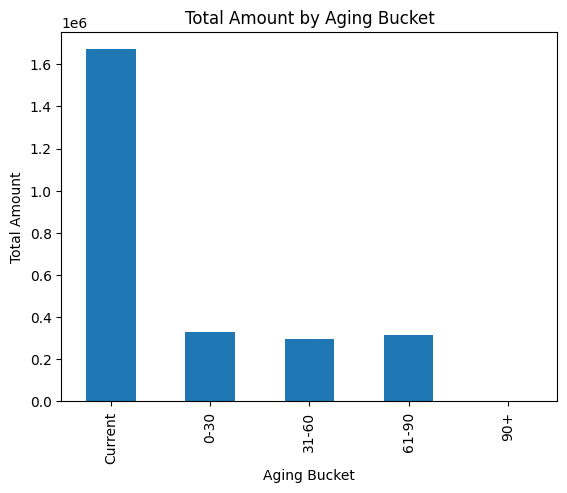

In [9]:
# Vizualization of the total amounts for each aging bucket.

aging_bucket_table.plot(
    x='aging_bucket',
    y='total_amount',
    kind='bar',
    title='Total Amount by Aging Bucket',
    xlabel='Aging Bucket',
    ylabel='Total Amount',
    legend=False,
)


In [12]:
# Created a column that will flag a vendor if their high risk count exceeds 6 invoices.

vendor_risk_kpi["escalation_flag"] = np.where(
    vendor_risk_kpi["high_risk_count"] > 25,
    "ESCALATE",
    "MONITOR"
)

vendor_risk_kpi

,vendor,total_unpaid_amount,unpaid_invoice_count,avg_days_overdue,high_risk_count,escalation_flag
exposure_rank,,,,,,
1,Dell,142155,46,39.63,44,ESCALATE
2,Walmart,114166,40,45.65,39,ESCALATE
3,FedEx,111285,45,40.11,43,ESCALATE
4,Staples,109241,41,51.15,40,ESCALATE
5,Best Buy,91991,28,53.18,27,ESCALATE
6,Grainger,90954,32,46.38,30,ESCALATE
7,UPS,78369,29,44.48,28,ESCALATE
8,Office Depot,71007,27,42.37,24,MONITOR
9,Costco,69227,27,44.93,22,MONITOR


<Axes: title={'center': 'Escalation Flag Distribution'}>

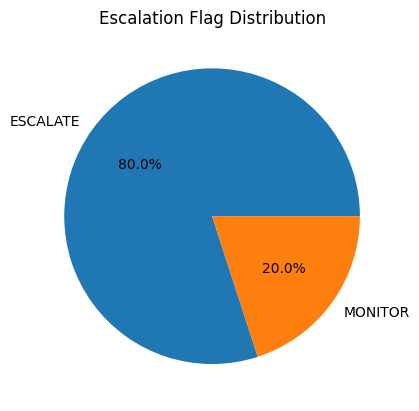

In [13]:
# Visualized the distribution of escalation flags.

escalation_count = vendor_risk_kpi['escalation_flag'].value_counts()
escalation_count

escalation_count.plot(
    kind='pie',
    autopct='%1.1f%%',
    title='Escalation Flag Distribution',
    ylabel=''
)

In [ ]:
# Summary

# 1. Identified vendors with highest unpaid financial exposure.
# 2. Ranked vendors based on unpaid balances and risk indicators.
# 3. Flagged vendors requiring escalation due to high-risk invoices.
# 4. Created aging analysis to highlight overdue concentration.
# 5. Visualized the top 5 vendors with highest exposure.
# 6. Visualized the risk exposure amount separated into aging buckets.
# 7. Visualized the escalation flag distribution to show the breakdown of vendors that need to resolved immediately.